In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/training_images"

Streaming output truncated to the last 5000 lines.
  inflating: training_images/Triangle/Triangle_602ce5b6-2a93-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_6038fd7e-2a84-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_603dcc1c-2a86-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_604221fe-2a8b-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_604bc47e-2a87-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_604f0b42-2a92-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_6053acd2-2a8e-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_605bc7b6-2a8c-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_6078d41e-2a91-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_608147a4-2a99-11ea-8123-8363a7ec19e6.png  
  inflating: training_images/Triangle/Triangle_60

In [ ]:
! unzip "/content/drive/MyDrive/test_images"

Streaming output truncated to the last 5000 lines.
  inflating: test_images/Square/Square_7d8f0c98-2a92-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7db1363e-2a91-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7db4415c-2a83-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7db5fc7a-2a99-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7dd0b4f4-2a88-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7dee7662-2a86-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7e1cd6a0-2a8c-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7e72e274-2a8d-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7e75ad44-2a90-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7e7c9770-2a96-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7e7e87fc-2a8b-11ea-8123-8363a7ec19e6.png  
  inflating: test_images/Square/Square_7ec1d474

In [ ]:
import os 
import shutil
import glob
import random
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F

In [ ]:
# # Code to split the dataset into training and test set 
# # the training and test folder are created as required by ImageFolder in the format training_images/class/.*png 

# random.seed(42)
# torch.manual_seed(42)
# path = os.getcwd()
# classes = ["Circle", "Square", "Octagon", "Heptagon", "Nonagon", "Star", "Hexagon", "Pentagon", "Triangle"]

# training_files = glob.glob(os.path.join(path, "geometry_dataset/training_images/*.png"))
# test_files = glob.glob(os.path.join(path, "geometry_dataset/test_images/*.png"))

# for training_file, test_file in zip(training_files, test_files):
#     os.remove(training_file)
#     os.remove(test_file)

# os.mkdir(os.path.join(path, "geometry_dataset/training_images"))
# os.mkdir(os.path.join(path, "geometry_dataset/test_images"))

# for class_ in classes:
#     image_location = os.path.join(path, "geometry_dataset/output")
#     image_location = os.path.join(image_location, class_ + "*.png")
#     class_images = glob.glob(image_location)
#     random.shuffle(class_images)
#     train_directory = os.path.join(path, "geometry_dataset/training_images/"+str(class_))
#     test_directory = os.path.join(path, "geometry_dataset/test_images/"+str(class_))
#     os.mkdir(train_directory)
#     os.mkdir(test_directory)
#     for train_images in class_images[0:8000]:
#         shutil.copy(train_images, "geometry_dataset/training_images/"+str(class_))
#     for test_images in class_images[8000:]:
#         shutil.copy(test_images, "geometry_dataset/test_images/"+str(class_))

In [ ]:
# Code to calculate the mean and standard deviation of the dataset 
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(os.path.join(os.getcwd(),"training_images"),transform=transform)
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
mean = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_loader.dataset)

var = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(train_loader.dataset)*200*200))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(18432, 128),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc1(torch.flatten(x,start_dim=1))
        x = self.fc2(x)
        return x

In [ ]:
def train(batch_size, model, device, train_loader, optimizer, epoch):
    model.train()
    tot_loss = 0
    correct  = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss   = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        pred    = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

        tot_loss = tot_loss + loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), tot_loss/(batch_idx+1), 100.0*correct/((batch_idx+1)*batch_size)))

    loss = tot_loss / len(train_loader)
    acc = 100.0 * correct / (len(train_loader) * batch_size)
    print('End of Epoch: {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(loss, acc))
    return loss,acc

def test(batch_size, model, device, test_loader):
    model.eval()
    tot_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            tot_loss     += torch.nn.CrossEntropyLoss()(output, target).item()  # sum up batch loss
            pred         = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct      += pred.eq(target.view_as(pred)).sum().item()

    loss = tot_loss / len(test_loader)
    acc = 100.0 * correct / (len(test_loader) * batch_size)
    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(loss, acc))
    return loss, acc

In [ ]:
batch_size = 64
epochs = 5

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
train_dataset = datasets.ImageFolder(os.path.join(os.getcwd(),"training_images"),transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(os.getcwd(),"test_images"),transform=transform)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,amsgrad=True)

train_losses,train_accuracy = [],[]
test_losses,test_accuracy = [],[]
scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, epochs + 1):
    train_loss,train_acc = train(batch_size, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(batch_size,model, device, test_loader)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    scheduler.step()

    if test_loss < 1e-4 or math.isclose(test_acc, 100.0):
        break

# torch.save(model.state_dict(), "0602-659026651-Chintakunta.pt")

Train Epoch: 1 [0/72000 (0%)]	Loss: 2.225750, Accuracy: 15.62%
Train Epoch: 1 [6400/72000 (9%)]	Loss: 2.083621, Accuracy: 18.10%
Train Epoch: 1 [12800/72000 (18%)]	Loss: 1.937907, Accuracy: 23.73%
Train Epoch: 1 [19200/72000 (27%)]	Loss: 1.780912, Accuracy: 29.66%
Train Epoch: 1 [25600/72000 (36%)]	Loss: 1.583512, Accuracy: 38.19%
Train Epoch: 1 [32000/72000 (44%)]	Loss: 1.402126, Accuracy: 45.95%
Train Epoch: 1 [38400/72000 (53%)]	Loss: 1.242159, Accuracy: 52.59%
Train Epoch: 1 [44800/72000 (62%)]	Loss: 1.114248, Accuracy: 57.81%
Train Epoch: 1 [51200/72000 (71%)]	Loss: 1.008613, Accuracy: 62.06%
Train Epoch: 1 [57600/72000 (80%)]	Loss: 0.919493, Accuracy: 65.59%
Train Epoch: 1 [64000/72000 (89%)]	Loss: 0.842412, Accuracy: 68.59%
Train Epoch: 1 [70400/72000 (98%)]	Loss: 0.778796, Accuracy: 71.06%
End of Epoch: 1
Training Loss: 0.765403, Training Accuracy: 71.58%
Test Loss: 0.165565, Test Accuracy: 94.47%
Train Epoch: 2 [0/72000 (0%)]	Loss: 0.101714, Accuracy: 96.88%
Train Epoch: 2 [64

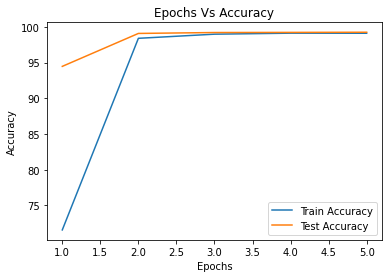

In [ ]:
epochs = list(range(1,epochs+1))
plt.plot(epochs,train_accuracy,label="Train Accuracy")
plt.plot(epochs,test_accuracy,label="Test Accuracy")
plt.title("Epochs Vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

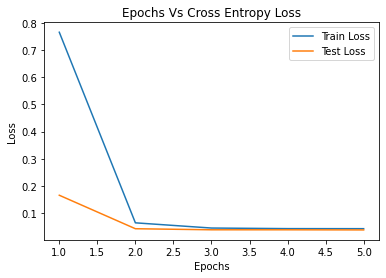

In [ ]:
plt.plot(epochs,train_losses,label="Train Loss")
plt.plot(epochs,test_losses,label="Test Loss")
plt.title("Epochs Vs Cross Entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()